In [1]:
# import necessary python packages 
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read auto.csv dataset
header = 0
index_col = None
names = ['date', 'time', 'type', 'state', 'location', 'be']
# auto_df = pd.read_csv('dataset_modified.csv',index_col = index_col, header = header ,names = names)
auto_df = pd.read_csv('dataset_modified_v2.csv',index_col = 0)
# explore dtypes. Name is regarded as string object. Pandas recognizes it as non-numerical data 
# and automatically excludes this column from all the statistical analyses below. 

print(auto_df.dtypes)
# head and tail of the dataframe
auto_df

date        object
time        object
type        object
state       object
location    object
BE          object
dtype: object


,date,time,type,state,location,BE
0,02/02/2009,07:15:17,M35,ON,R1_Bed_to_Toilet,begin
1,02/02/2009,07:15:21,AD1-A,2.82231,NaN,NaN
2,02/02/2009,07:15:23,M35,OFF,NaN,NaN
3,02/02/2009,07:15:23,M35,ON,NaN,NaN
4,02/02/2009,07:15:28,AD1-A,2.79926,NaN,NaN
...,...,...,...,...,...,...
137869,04/04/2009,07:26:16,M48,OFF,NaN,NaN
137870,04/04/2009,07:27:47,M48,ON,NaN,NaN
137871,04/04/2009,07:27:50,M47,ON,NaN,NaN
137872,04/04/2009,07:27:59,M47,OFF,NaN,NaN


In [3]:
## delete the error 'begin' or 'end'
## for two 'end' appear continuously, if there are other events happens betweern this two 'end',
## delete second 'end', otherwise delete first. 
## It's the same for the error'begin'

def fuze(auto_df):
    i0=[]
    name1 = ['R1_Bed_to_Toilet','R1_Personal_Hygiene', 'R2_Bed_to_Toilet',
           'Meal_Preparation', 'R2_Personal_Hygiene', 'Watch_TV', 'R1_Work',
           'R2_Work', 'R1_Sleep', 'R2_Sleep', 'Wash_Bathtub', 'Clean',
           'Study']
    for j in range(len(name1)):
        temp=[0,0]
        cnt = 0
        flag = 0
        for i in range(auto_df.shape[0] - 2):
            
            if auto_df['location'][i] == name1[j]:
                temp[cnt] = auto_df['BE'][i]
                i0.append(i)
                if cnt == 0:
                    cnt = 1
                else:
                    cnt = 0
                if temp[0] == 'end' and temp[1] == 'end':
                    print(name1[j], 'end error:',i0[-2], i)
                    for k in range(i0[-2] + 1, i-1):
                        if auto_df['location'][k] != 'NaN':
                            flag = 1
                            break
                    if flag == 1:
                        auto_df = auto_df.drop(i)
                    else:
                        auto_df = auto_df.drop(i0[-2])
                    auto_df = auto_df.reset_index(drop = True)
                    flag = 0;
                elif temp[0] == 'begin' and temp[1] == 'begin':
                    print(name1[j], 'begin error:',i0[-2], i)
                    for k in range(i0[-2] + 1, i-1):
                        if auto_df['location'][k] != 'NaN':
                            flag = 1
                            break
                    if flag == 1:
                        auto_df = auto_df.drop(i0[-2])
                    else:
                        auto_df = auto_df.drop(i)
                    auto_df = auto_df.reset_index(drop = True)
                    flag = 0;
                    
    ## generate dictionary containing date, for further use in prophet 
    
    dic = {}
    for i in range(auto_df.shape[0]):
        if auto_df['location'][i] is not np.nan:
            if auto_df['location'][i] in dic:
                dic[auto_df['location'][i]].append(pd.to_datetime(auto_df['date'][i] + ' ' +  auto_df['time'][i],format = '%d/%m/%Y %H:%M:%S'))
                dic[auto_df['location'][i]+'_date'].append(auto_df['date'][i])
            else:
                dic[auto_df['location'][i]] = [pd.to_datetime(auto_df['date'][i] + ' ' + auto_df['time'][i],format = '%d/%m/%Y %H:%M:%S')]
                dic[auto_df['location'][i]+'_date'] = [auto_df['date'][i]]
    dic_delta = {}
    for i in name1:
        time = []
        for j in range(int(len(dic[i])/2)):
            time.append(((dic[i][2*j+1] - dic[i][2*j]).total_seconds())/3600)
        dic_delta[i] = time


    return [dic, dic_delta]

In [4]:


[dic, dic_delta] = fuze(auto_df)
import copy
dic_temp = copy.deepcopy(dic)
dic_delta_temp = copy.deepcopy(dic_delta)
    # R2_Sleep_begin = []
    # R2_Sleep_end = []
    # R2_Sleep_begin_date = []
    # R2_Sleep_end_date = []
    # for i in range(len(dic['R2_Sleep'])):
    #     if i%2 == 0:
    #         R2_Sleep_begin.append(dic['R2_Sleep'][i])
    #         R2_Sleep_begin_date.append(dic['R2_Sleep_date'][i])
    #     else:
    #         R2_Sleep_end.append(dic['R2_Sleep'][i])
    #         R2_Sleep_end_date.append(dic['R2_Sleep_date'][i])

In [5]:
## use a temperory parameter, easier to re-run code.
dic = copy.deepcopy(dic_temp)
dic_delta = copy.deepcopy(dic_delta_temp)
name1 = ['R1_Bed_to_Toilet','R1_Personal_Hygiene', 'R2_Bed_to_Toilet',
           'Meal_Preparation', 'R2_Personal_Hygiene', 'Watch_TV', 'R1_Work',
           'R2_Work', 'R1_Sleep', 'R2_Sleep', 'Wash_Bathtub', 'Clean',
           'Study']
for i in name1:
    date_time = []
    for j in range(len(dic[i])):
        if j % 2 != 0:
            date_time.append(dic[i][j])
    dic[i+'_date_time'] = date_time
    


In [6]:
# import datetime
Sleep = ['R1_Sleep', 'R2_Sleep']
# for i in Sleep:
#     cnt = 0
#     for j in range(int((dic[i + '_date_time'][-1] - dic[i + '_date_time'][0]).total_seconds()/60/60//24)):
#     # for j in range(int(len(dic[i+'_date_time']))):    
#         # if dic[i+'_date_time'][j].day + 1 != dic[i+'_date_time'][j+1].day and dic[i+'_date_time'][j].day != 31:
#         if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day:
#             cnt = cnt + 1
#             dic[i+'_date_time'].insert(j+1, dic[i+'_date_time'][j]+datetime.timedelta(1))
#             # dic_delta[i].insert(j+1, dic_delta[i][j])
#             # print(dic[i+'_date_time'][j])
#         else:
#             if cnt > 0:
#                 for k in range(cnt):
#                 # dic_delta[i].insert(j+1, dic_delta[i][j])
#                     # print(cnt, j - cnt + 1 + k,j - 2 * cnt + 1 + k) 
#                     dic[i+'_date_time'][j - cnt +1 + k] = dic[i+'_date_time'][j - 2 * cnt + 1 + k]+datetime.timedelta(cnt)
#                     dic_delta[i].insert(j - cnt + 1 + k, (dic_delta[i][j - 2 * cnt + 1 + k]+dic_delta[i][j + 2 * cnt - 1 - k])/2)
# #                 cnt = 0

In [7]:
## some events happens both night and morning, split them.

for i in [name for name in name1 if name not in Sleep]:

    dic[i+'_morning_date_time'] = [];
    dic[i+'_night_date_time'] = [];
    dic_delta[i+'_morning'] = [];
    dic_delta[i+'_night'] = [];    
    for j in range(len(dic[i+'_date_time'])):
        if dic[i+'_date_time'][j].hour < 12:
            dic[i+'_morning_date_time'].append(dic[i+'_date_time'][j])
            dic_delta[i+'_morning'].append(dic_delta[i][j])
        else:
            dic[i+'_night_date_time'].append(dic[i+'_date_time'][j])
            dic_delta[i+'_night'].append(dic_delta[i][j])

In [8]:
## backup code

# import datetime
# # for i in [name for name in name1 if name not in Sleep]:
# for i in ['R1_Sleep', 'R2_Sleep', 'R1_Personal_Hygiene_morning', 'R1_Personal_Hygiene_night','R1_Bed_to_Toilet', 'R2_Bed_to_Toilet',
#            'Meal_Preparation', 'R2_Personal_Hygiene_morning', 'R2_Personal_Hygiene_night','Meal_Preparation_night']:
# # for i in ['R1_Personal_Hygiene', 'R1_Personal_Hygiene']:
#     # location = {}
#     print(i)
#     cnt = 0
#     # for j in range(int(len(dic[i+'_date_time'])) - 1): 
#     #     date_cnt = 0
#     #     if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day\
#     #     and dic[i+'_date_time'][j].day != dic[i+'_date_time'][j+1].day:
#     #         while dic[i+'_date_time'][j - date_cnt].day >= - dic[i+'_date_time'][j+1].day + 2*dic[i+'_date_time'][j].day + 1:
#     #             if j - date_cnt > 0:
#     #                 date_cnt += 1
#     #             else:
#     #                 break
#     #         location[j + 1] = date_cnt + 1
#     j = 0
#     while dic[i+'_date_time'][j] < dic[i+'_date_time'][-1]:
#         date_cnt = 0
#         rep_cnt = 0
#         if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day\
#         and dic[i+'_date_time'][j].day != dic[i+'_date_time'][j+1].day:
#             while dic[i+'_date_time'][j - date_cnt].day > - dic[i+'_date_time'][j+1].day + 2*dic[i+'_date_time'][j].day + 1 or (dic[i+'_date_time'][j]+ datetime.timedelta(date_cnt)).month < dic[i+'_date_time'][j+1].month :
#                 if j - date_cnt > 0:
#                     date_cnt += 1
#                 else:
#                     date_cnt = 1
#                     break
#             for k in range(date_cnt):
#                 # dic[i+'_date_time'].insert(j+1,dic[i+'_date_time'][j - k] + datetime.timedelta(dic[i+'_date_time'][j+1].day - dic[i+'_date_time'][j].day))             
#                 if dic[i+'_date_time'][j - k].day == dic[i+'_date_time'][j - k - 1].day:
#                     rep_cnt += 1
#             for k in range(date_cnt):
#                 dic[i+'_date_time'].insert(j+1,dic[i+'_date_time'][j - k] + datetime.timedelta(date_cnt - rep_cnt))  
#                 dic_delta[i].insert(j + 1, dic_delta[i][j - k])                
#             j += date_cnt
#         j += 1
#     m = 0
#     while dic[i+'_date_time'][m] < dic[i+'_date_time'][-1]:
#         if dic[i+'_date_time'][m].day == dic[i+'_date_time'][m + 1].day:
#             del dic[i+'_date_time'][m]
#             del dic_delta[i][m]
#         else:
#             m += 1
    
#     for j in location:
#         for k in range(location[j]):
#             # print(j,k)
#             dic[i+'_date_time'].insert(j+cnt, dic[i+'_date_time'][j + cnt - k - 1] + datetime.timedelta(location[j]))
#             print(j+cnt, dic[i+'_date_time'][j + cnt - k - 1]+ datetime.timedelta(location[j]), location[j])            
#         cnt = cnt + location[j]
            
#         if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day:
#             cnt = cnt + 1
#             dic[i+'_date_time'].insert(j+1, dic[i+'_date_time'][j]+datetime.timedelta(1))
#             dic_delta[i].insert(j+1, (dic_delta[i][j - k]+dic_delta[i][j+k])/2)
#             # print(dic[i+'_date_time'][j])
#         else:
#             if cnt > 0:
#                 for k in range(cnt):
#                 # dic_delta[i].insert(j+1, dic_delta[i][j])
#                     # print(cnt, j - cnt + 1 + k,j - 2 * cnt + 1 + k) 
#                     dic[i+'_date_time'][j - cnt +1 + k] = dic[i+'_date_time'][j - 2 * cnt + 1 + k]+datetime.timedelta(cnt)
#                     dic_delta[i].insert(j - cnt + 1 + k, dic_delta[i][j - 2 * cnt + 1 + k])
# #                 cnt = 0

In [9]:
## fill the data in missed dates,
## becasue propjhet is sensitive to continuous dates.

import datetime
# for i in [name for name in name1 if name not in Sleep]:
for i in ['R1_Sleep', 'R2_Sleep', 'R1_Personal_Hygiene_morning','R1_Personal_Hygiene', 'R1_Personal_Hygiene_night','R1_Bed_to_Toilet', 'R2_Bed_to_Toilet','R1_Bed_to_Toilet_morning',
           'Meal_Preparation', 'R2_Personal_Hygiene_morning', 'R2_Personal_Hygiene_night','Meal_Preparation_night']:
# for i in ['R1_Personal_Hygiene', 'R1_Personal_Hygiene']:
    # location = {}
    print(i)
    cnt = 0
    # for j in range(int(len(dic[i+'_date_time'])) - 1): 
    #     date_cnt = 0
    #     if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day\
    #     and dic[i+'_date_time'][j].day != dic[i+'_date_time'][j+1].day:
    #         while dic[i+'_date_time'][j - date_cnt].day >= - dic[i+'_date_time'][j+1].day + 2*dic[i+'_date_time'][j].day + 1:
    #             if j - date_cnt > 0:
    #                 date_cnt += 1
    #             else:
    #                 break
    #         location[j + 1] = date_cnt + 1
    j = 0
    while dic[i+'_date_time'][j] < dic[i+'_date_time'][-1]:
        date_cnt = 0
        rep_cnt = 0
        if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day\
        and dic[i+'_date_time'][j].day != dic[i+'_date_time'][j+1].day:
            month_cnt = 0
            # while dic[i+'_date_time'][j - date_cnt].day > - dic[i+'_date_time'][j+1].day + 2*dic[i+'_date_time'][j].day + 1 or dic[i+'_date_time'][j].month < dic[i+'_date_time'][j+1].month:
            while (dic[i+'_date_time'][j]-datetime.timedelta(date_cnt)).day > - dic[i+'_date_time'][j+1].day + 2*dic[i+'_date_time'][j].day + 1or dic[i+'_date_time'][j].month < dic[i+'_date_time'][j+1].month :
                month_cnt += 1
                if j - date_cnt > 0:
                    date_cnt += 1
                else:
                    date_cnt = 1
                    break
            for k in range(date_cnt):
                # dic[i+'_date_time'].insert(j+1,dic[i+'_date_time'][j - k] + datetime.timedelta(dic[i+'_date_time'][j+1].day - dic[i+'_date_time'][j].day))             
                if dic[i+'_date_time'][j - k].day == dic[i+'_date_time'][j - k - 1].day:
                    rep_cnt += 1
            for k in range(date_cnt):
                dic[i+'_date_time'].insert(j+1,dic[i+'_date_time'][j - k] + datetime.timedelta(date_cnt - rep_cnt))  
                if j + 2 * date_cnt - k < len(dic_delta[i]):
                    dic_delta[i].insert(j + 1, (dic_delta[i][j - k] + dic_delta[i][j + 2 * date_cnt - k])/2) 

                else:
                    dic_delta[i].insert(j + 1, (dic_delta[i][j - k] + dic_delta[i][-1])/2) 
            j += date_cnt
        j += 1
    # m = 0
    # while dic[i+'_date_time'][m] < dic[i+'_date_time'][-1]:
    #     if dic[i+'_date_time'][m].day == dic[i+'_date_time'][m + 1].day:
    #         del dic[i+'_date_time'][m]
    #         del dic_delta[i][m]
    #     else:
    #         m += 1
dic['R1_Sleep_date_time'].insert(27, dic['R1_Sleep_date_time'][26]+datetime.timedelta(1))    
dic_delta['R1_Sleep'].insert(27, (dic_delta['R1_Sleep'][28]+dic_delta['R1_Sleep'][25])/2) 
# dic['R1_Personal_Hygiene_morning_date_time'].insert(27, dic['R1_Personal_Hygiene_morning_date_time'][25]+datetime.timedelta(2))
# dic['R1_Personal_Hygiene_morning_date_time'].insert(28, dic['R1_Personal_Hygiene_morning_date_time'][26]+datetime.timedelta(2))
# dic_delta['R1_Personal_Hygiene_morning'].insert(27, (dic_delta['R1_Personal_Hygiene_morning'][29]+dic_delta['R1_Personal_Hygiene_morning'][25])/2)
# dic_delta['R1_Personal_Hygiene_morning'].insert(28, (dic_delta['R1_Personal_Hygiene_morning'][30]+dic_delta['R1_Personal_Hygiene_morning'][26])/2)    

    # for j in location:
    #     for k in range(location[j]):
    #         # print(j,k)
    #         dic[i+'_date_time'].insert(j+cnt, dic[i+'_date_time'][j + cnt - k - 1] + datetime.timedelta(location[j]))
    #         print(j+cnt, dic[i+'_date_time'][j + cnt - k - 1]+ datetime.timedelta(location[j]), location[j])            
    #     cnt = cnt + location[j]
            
#         if (dic[i+'_date_time'][j] + datetime.timedelta(1)).day != dic[i+'_date_time'][j+1].day:
#             cnt = cnt + 1
#             dic[i+'_date_time'].insert(j+1, dic[i+'_date_time'][j]+datetime.timedelta(1))
#             # dic_delta[i].insert(j+1, dic_delta[i][j])
#             # print(dic[i+'_date_time'][j])
#         else:
#             if cnt > 0:
#                 for k in range(cnt):
#                 # dic_delta[i].insert(j+1, dic_delta[i][j])
#                     # print(cnt, j - cnt + 1 + k,j - 2 * cnt + 1 + k) 
#                     dic[i+'_date_time'][j - cnt +1 + k] = dic[i+'_date_time'][j - 2 * cnt + 1 + k]+datetime.timedelta(cnt)
#                     dic_delta[i].insert(j - cnt + 1 + k, dic_delta[i][j - 2 * cnt + 1 + k])
# #                 cnt = 0

R1_Sleep
R2_Sleep
R1_Personal_Hygiene_morning
R1_Personal_Hygiene
R1_Personal_Hygiene_night
R1_Bed_to_Toilet
R2_Bed_to_Toilet
R1_Bed_to_Toilet_morning
Meal_Preparation
R2_Personal_Hygiene_morning
R2_Personal_Hygiene_night
Meal_Preparation_night


In [10]:
R2_Sleep_begin = []
R2_Sleep_end = []
R2_Sleep_begin_date = []
R2_Sleep_end_date = []
for i in range(len(dic['R2_Sleep'])):
    if i%2 == 0:
        R2_Sleep_begin.append(dic['R2_Sleep'][i])
        R2_Sleep_begin_date.append(dic['R2_Sleep_date'][i])
    else:
        R2_Sleep_end.append(dic['R2_Sleep'][i])
        R2_Sleep_end_date.append(dic['R2_Sleep_date'][i])

In [11]:
# x1 = []
# x2=[]
# y1=[]
# y2=[]
# Sleep_delta = []
# for i in range(len(R2_Sleep_begin)):
#     y1.append(R2_Sleep_begin[i].hour)
#     y2.append(R2_Sleep_end[i].hour)
#     Sleep_delta.append(((dic['R2_Sleep'][2*i+1] - dic['R2_Sleep'][2*i]).total_seconds())/3600)

#     if y1[i] < 12:
#         y1[i] = + y1[i] + 24
# # fig = plt.figure()
# # ax = fig.add_subplot(1, 1, 1)
# # ax.plot(R2_Sleep_begin_date, Sleep_delta, color='tab:blue')
# # ax.plot(R2_Sleep_end_date, y2, color='tab:orange')
# # ax.plot(R2_Sleep_end_date, y2, color='tab:orange')

# fig, ax = plt.subplots(figsize = (20,10))

# ax.bar(R2_Sleep_end_date, Sleep_delta, 0.35,  label = 'sleep time', color = 'tab:orange')
# ax.plot(R2_Sleep_end_date, y2, color='tab:blue',label = 'sleep end time')
# ax.plot(R2_Sleep_end_date, y1, color='tab:red', label = 'sleep begin time')
# # ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,
# #        label='Women')
# plt.xticks(rotation='vertical')
# ax.set_ylabel('time/hour')
# ax.set_title('date')
# ax.legend()

# plt.show()

In [12]:
## holiday test 

# playoffs = pd.DataFrame({
#   'holiday': 'playoff',
#   'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                         '2010-01-24', '2010-02-07', '2011-01-08',
#                         '2013-01-12', '2014-01-12', '2014-01-19',
#                         '2014-02-02', '2015-01-11', '2016-01-17',
#                         '2016-01-24', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# superbowls = pd.DataFrame({
#   'holiday': 'superbowl',
#   'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# holidays = pd.concat((playoffs, superbowls))
# m = Prophet(holidays=holidays)
# m.add_country_holidays(country_name='US')
# m.fit(df)

In [13]:
# whe = pd.Series(data=a2, name='whe')
# whe

In [14]:
rain1 = pd.read_csv('rain.csv')
rain2 = pd.read_csv('rain2.csv')

In [15]:
whe = rain1['summary'][39:66].values.tolist()+rain2['summary'][7:41].values.tolist()
whe2 = whe + rain2['summary'][41:48].values.tolist()
whe = list(map(float,whe))
whe2 = list(map(float,whe2))
whe_future = pd.Series(data=whe2, name='whe')

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -129.494
Iteration  1. Log joint probability =    59.3759. Improved by 188.869.
Iteration  2. Log joint probability =    97.3376. Improved by 37.9617.
Iteration  3. Log joint probability =    125.911. Improved by 28.573.
Iteration  4. Log joint probability =    125.913. Improved by 0.00285881.
Iteration  5. Log joint probability =    125.928. Improved by 0.0147975.
Iteration  6. Log joint probability =     125.93. Improved by 0.00215611.
Iteration  7. Log joint probability =    131.409. Improved by 5.47812.
Iteration  8. Log joint probability =    131.413. Improved by 0.00423247.
Iteration  9. Log joint probability =    131.445. Improved by 0.0323739.
Iteration 10. Log joint probability =    131.467. Improved by 0.0214045.
Iteration 11. Log joint probability =    131.477. Improved by 0.0109543.
Iteration 12. Log joint probability =    131.503. Improved by 0.0254123.
Iteration 13. Log joint probability =    131.533. Improved by 0.030037.
Iteration 14. Lo

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pa

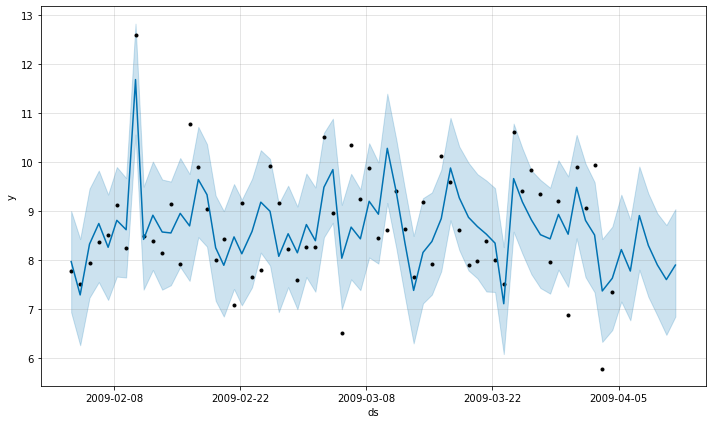

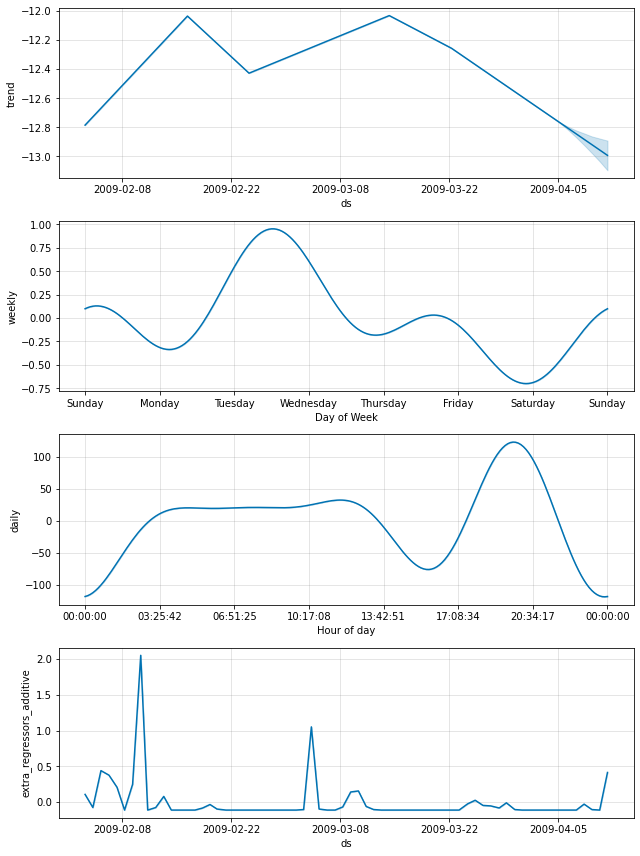

In [16]:
from prophet import Prophet
# data = {'ds' : dic['R1_Personal_Hygiene_morning_date_time'], 'y' : dic_delta['R1_Personal_Hygiene_morning']}
# data = {'ds' : dic['Meal_Preparation_night_date_time'], 'y' : dic_delta['Meal_Preparation_night']}
data = {'ds' : dic['R1_Sleep_date_time'], 'y' : dic_delta['R1_Sleep'], 'whe' : whe}
df = pd.DataFrame(data)

m = Prophet(changepoint_prior_scale = 1)
# m = Prophet(holidays=holidays)
# m.add_country_holidays(country_name='US')
# m.fit(df)
m.add_regressor('whe')

m.fit(df)
future = m.make_future_dataframe(periods=7)

future = pd.concat([future,whe_future],axis = 1)

future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


In [143]:
df.head(10)

,ds,y,whe
0,2009-02-03 05:57:22,7.774167,7.513079
1,2009-02-04 05:56:32,7.513333,6.646185
2,2009-02-05 06:51:02,7.933889,4.334469
3,2009-02-06 07:33:48,8.366389,0.000000
4,2009-02-07 08:23:03,8.506389,4.912398
5,2009-02-08 07:33:48,9.131528,29.474386
6,2009-02-09 08:23:03,8.257917,0.000000
7,2009-02-10 09:21:45,12.600278,0.481608
8,2009-02-11 06:51:02,8.490556,2.600681
9,2009-02-12 07:33:48,8.397083,0.000000


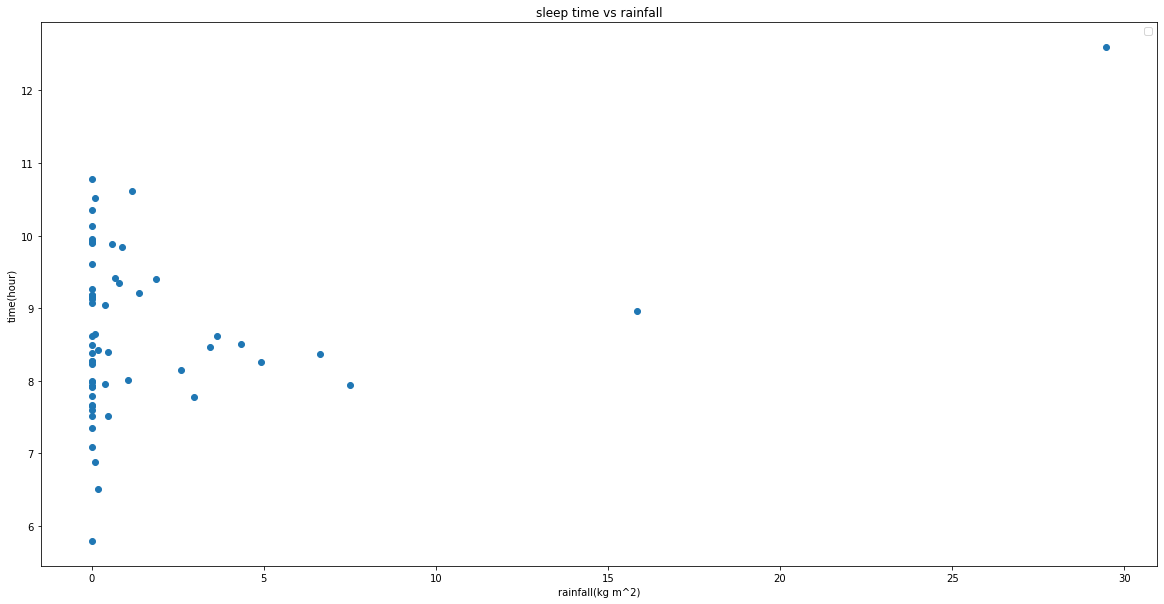

In [90]:
df.sort_values(by= ['whe'], inplace = True)
df

fig, ax = plt.subplots(figsize = (20,10))

ax.scatter(df['whe'],df['y'])
ax.set_ylabel('time(hour)')
ax.set_xlabel('rainfall(kg m^2)')
ax.set_title('sleep time vs rainfall')
ax.legend()

plt.show()

In [122]:
df[]

,ds,y,whe
30,2009-03-05 06:42:32,6.509722,0
24,2009-02-27 07:49:14,8.232778,0
23,2009-02-26 06:51:50,9.170833,0
60,2009-04-04 07:08:46,7.354167,0
21,2009-02-24 07:01:35,7.791667,0
3,2009-02-06 07:33:48,8.366389,0
43,2009-03-18 07:35:52,8.619861,0
57,2009-04-01 07:46:36,9.070556,0
6,2009-02-09 08:23:03,8.257917,0
22,2009-02-25 07:33:25,9.924444,0


In [107]:
df

,ds,y,whe
30,2009-03-05 06:42:32,6.509722,0
25,2009-02-28 08:23:34,7.592500,0
29,2009-03-04 07:00:05,8.958611,0
59,2009-04-03 04:25:31,5.789444,0
36,2009-03-11 07:46:44,9.415278,0
...,...,...,...
33,2009-03-08 07:35:52,9.885556,3.6416404
2,2009-02-05 06:51:02,7.933889,4.334469
4,2009-02-07 08:23:03,8.506389,4.912398
1,2009-02-04 05:56:32,7.513333,6.6461854


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -154.552
Iteration  1. Log joint probability =    47.1814. Improved by 201.733.
Iteration  2. Log joint probability =    76.5548. Improved by 29.3734.
Iteration  3. Log joint probability =    80.9726. Improved by 4.41777.
Iteration  4. Log joint probability =     80.974. Improved by 0.00146537.
Iteration  5. Log joint probability =    81.2278. Improved by 0.253726.
Iteration  6. Log joint probability =    81.2315. Improved by 0.00376399.
Iteration  7. Log joint probability =     81.236. Improved by 0.00445984.
Iteration  8. Log joint probability =    81.2394. Improved by 0.00340013.
Iteration  9. Log joint probability =    81.2522. Improved by 0.0128402.
Iteration 10. Log joint probability =    81.2545. Improved by 0.00221811.
Iteration 11. Log joint probability =     81.273. Improved by 0.0185902.
Iteration 12. Log joint probability =    81.2838. Improved by 0.0107841.
Iteration 13. Log joint probability =    81.2842. Improved by 0.000421068.
Iteration

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pa

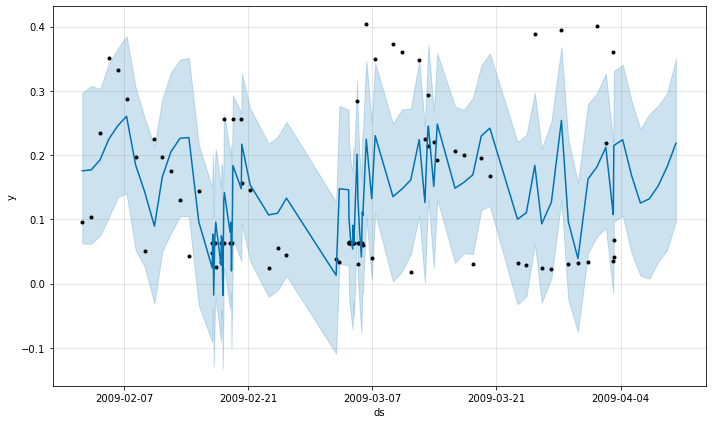

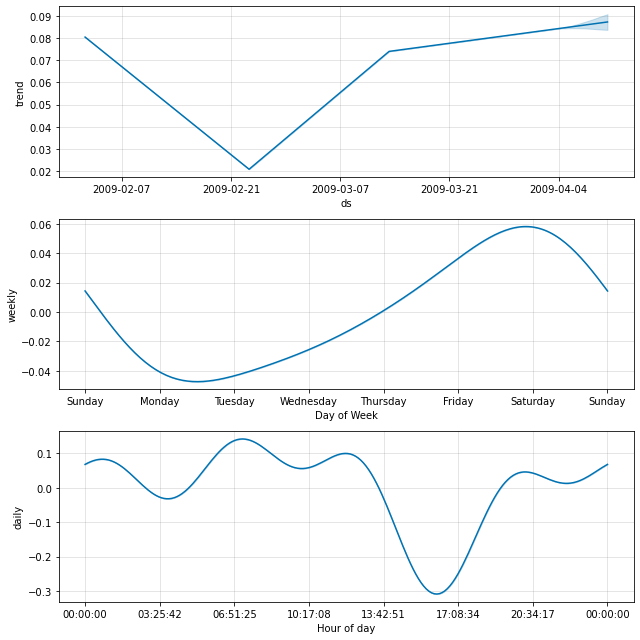

In [17]:
from prophet import Prophet

# data = {'ds' : dic['R1_Personal_Hygiene_morning_date_time'][:-7], 'y' : dic_delta['R1_Personal_Hygiene_morning'][:-7]}
# data = {'ds' : dic['R1_Sleep_date_time'], 'y' : dic_delta['R1_Sleep'], 'whe' : whe}
data = {'ds' : dic['R1_Bed_to_Toilet_date_time'], 'y' : dic_delta['R1_Bed_to_Toilet']}
df = pd.DataFrame(data)

m = Prophet(changepoint_prior_scale = 1)
# m = Prophet(holidays=holidays)
# m.add_country_holidays(country_name='US')
# m.fit(df)
# m.add_regressor('whe', mode='multiplicative')

m.fit(df)
future = m.make_future_dataframe(periods=7)

# future = pd.concat([future,whe_future],axis = 1)

future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -125.889
Iteration  1. Log joint probability =   -1.78698. Improved by 124.102.
Iteration  2. Log joint probability =    48.9465. Improved by 50.7334.
Iteration  3. Log joint probability =    48.9472. Improved by 0.000776612.
Iteration  4. Log joint probability =    49.1789. Improved by 0.231661.
Iteration  5. Log joint probability =    49.3867. Improved by 0.207752.
Iteration  6. Log joint probability =    50.2464. Improved by 0.859719.
Iteration  7. Log joint probability =    50.4166. Improved by 0.170215.
Iteration  8. Log joint probability =    50.4925. Improved by 0.0759338.
Iteration  9. Log joint probability =    50.9159. Improved by 0.423387.
Iteration 10. Log joint probability =    50.9267. Improved by 0.0107634.
Iteration 11. Log joint probability =     51.068. Improved by 0.141315.
Iteration 12. Log joint probability =    51.3766. Improved by 0.308572.
Iteration 13. Log joint probability =    51.3889. Improved by 0.0123665.
Iteration 14. Log 

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pa

0.42857142857142855


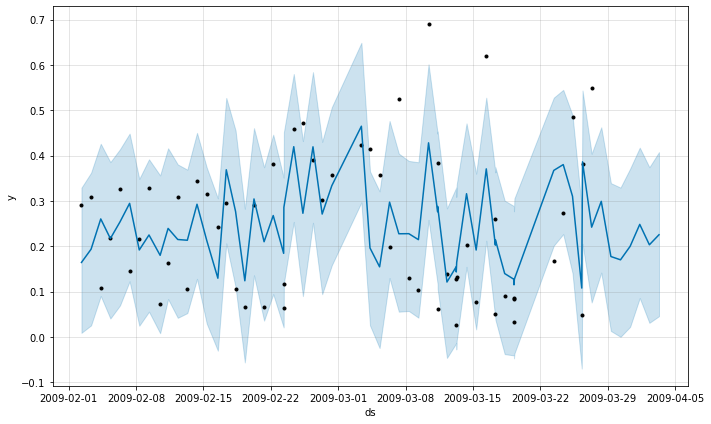

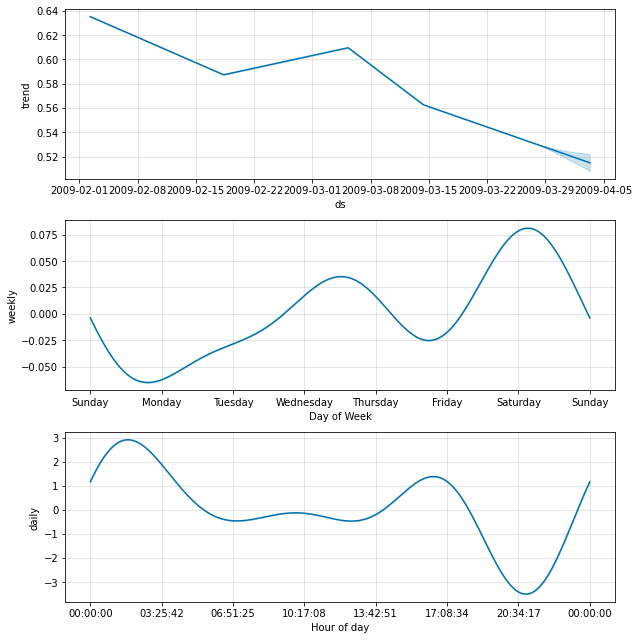

In [78]:
# [upper, lower] = pro(1)
# cnt = 0
# for i in range(57,64):
#     if dic_delta['R1_Personal_Hygiene_morning'][i] < upper[i] and dic_delta['R1_Personal_Hygiene_morning'][i] > lower[i]:
#         cnt = cnt + 1
# print(cnt/7)

In [53]:
dic_delta['R1_Personal_Hygiene_morning'][-7 :]


[0.09222222222222223,
 0.21166666666666667,
 0.29527777777777775,
 0.5602777777777778,
 0.13555555555555557,
 0.6083333333333333,
 0.04083333333333333]

In [67]:
cnt

3

In [64]:
for i in range(57, 64):
    print(upper[i])

0.48739189014331613
0.3625084725589209
0.36056422997580373
0.38409212898873435
0.43036779798608726
0.3952103753673835
0.4217209539346492


In [13]:
dic['R1_Personal_Hygiene_morning_date_time']

[Timestamp('2009-02-02 07:38:34'),
 Timestamp('2009-02-03 07:38:34'),
 Timestamp('2009-02-04 07:46:36'),
 Timestamp('2009-02-05 07:46:36'),
 Timestamp('2009-02-06 07:54:02'),
 Timestamp('2009-02-07 07:46:36'),
 Timestamp('2009-02-08 07:54:02'),
 Timestamp('2009-02-09 08:09:05'),
 Timestamp('2009-02-10 11:56:08'),
 Timestamp('2009-02-11 07:46:36'),
 Timestamp('2009-02-12 07:54:02'),
 Timestamp('2009-02-13 07:46:36'),
 Timestamp('2009-02-14 07:54:02'),
 Timestamp('2009-02-15 08:09:05'),
 Timestamp('2009-02-16 11:56:08'),
 Timestamp('2009-02-17 08:55:08'),
 Timestamp('2009-02-18 08:07:35'),
 Timestamp('2009-02-19 07:12:15'),
 Timestamp('2009-02-20 06:02:00'),
 Timestamp('2009-02-21 07:12:15'),
 Timestamp('2009-02-22 06:02:00'),
 Timestamp('2009-02-23 08:35:23'),
 Timestamp('2009-02-24 09:15:17'),
 Timestamp('2009-02-25 08:02:45'),
 Timestamp('2009-02-26 09:11:18'),
 Timestamp('2009-02-27 08:07:34'),
 Timestamp('2009-02-28 08:07:34'),
 Timestamp('2009-03-01 08:07:34'),
 Timestamp('2009-03-

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/proph

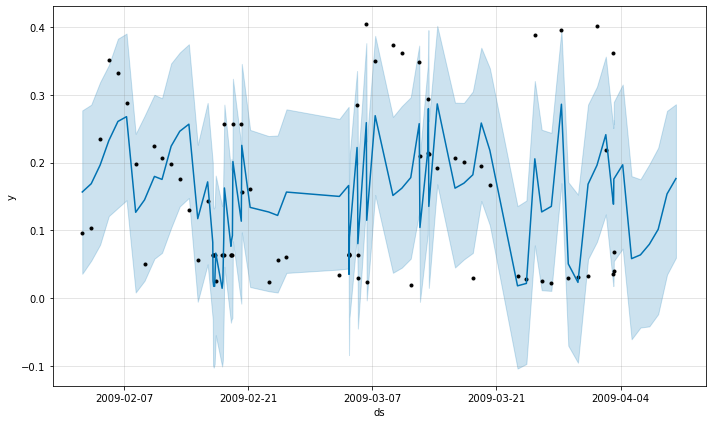

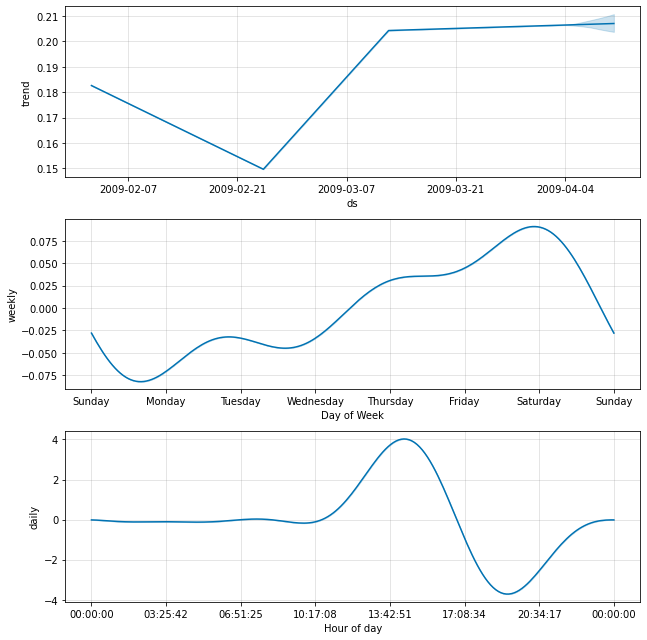

In [126]:
from prophet import Prophet
# data = {'ds' : dic['R1_Personal_Hygiene_morning_date_time'][:-3], 'y' : dic_delta['R1_Personal_Hygiene_morning'][:-3]}
# data = {'ds' : dic['R1_Sleep_date_time'], 'y' : dic_delta['R1_Sleep'], 'whe' : whe}
data = {'ds' : dic['R1_Bed_to_Toilet_morning_date_time'], 'y' : dic_delta['R1_Bed_to_Toilet_morning']}
df = pd.DataFrame(data)

m = Prophet(changepoint_prior_scale = 1)
# m = Prophet(holidays=holidays)
# m.add_country_holidays(country_name='US')
# m.fit(df)
# m.add_regressor('whe', mode='multiplicative')
# 
m.fit(df)
future = m.make_future_dataframe(periods=7)

# future = pd.concat([future,whe_future],axis = 1)

future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [108]:
fr = pd.read_csv('data_frequency2.csv')
fr1 = fr.drop(['Unnamed: 0', 'action'], axis = 1)
fr1

,M35,AD1-A,M34,M32,M33,M36,M30,M29,M37,M38,...,M01,M12,M03,M22,L09,D12,L10,L13,L12,L04
0,24.0,2.0,10.0,2.0,6.0,6.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.0,0.0,2.0,4.0,0.0,4.0,4.0,3.0,4.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,15.0,0.0,2.0,3.0,5.0,4.0,3.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,3.0,4.0,4.0,2.0,6.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,4.0,2.0,0.0,7.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
def prop(fle):
    data = {'ds' : dic['R1_Personal_Hygiene_morning_date_time'][:-7], 'y' : dic_delta['R1_Personal_Hygiene_morning'][:-7]}
    # data = {'ds' : dic['R1_Sleep_date_time'], 'y' : dic_delta['R1_Sleep'], 'whe' : whe}
    df = pd.DataFrame(data)

    m = Prophet(changepoint_prior_scale = fle)
    m.fit(df)
    future = m.make_future_dataframe(periods=1)

    # future = pd.concat([future,whe_future],axis = 1)

    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    return [forecast['yhat_upper'], forecast['yhat_lower']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -68.3239
Iteration  1. Log joint probability =   -1.76904. Improved by 66.5549.
Iteration  2. Log joint probability =     45.335. Improved by 47.104.
Iteration  3. Log joint probability =    45.3496. Improved by 0.0146451.
Iteration  4. Log joint probability =    45.3599. Improved by 0.0102188.
Iteration  5. Log joint probability =    45.3778. Improved by 0.0179787.
Iteration  6. Log joint probability =    45.4161. Improved by 0.0382159.
Iteration  7. Log joint probability =    45.4593. Improved by 0.0432528.
Iteration  8. Log joint probability =    45.5036. Improved by 0.0442865.
Iteration  9. Log joint probability =    50.6073. Improved by 5.10366.
Iteration 10. Log joint probability =    50.6228. Improved by 0.0155094.
Iteration 11. Log joint probability =    50.6731. Improved by 0.0503007.
Iteration 12. Log joint probability =    50.8089. Improved by 0.135853.
Iteration 13. Log joint probability =    50.8683. Improved by 0.0593679.
Iteration 14. Log

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pa

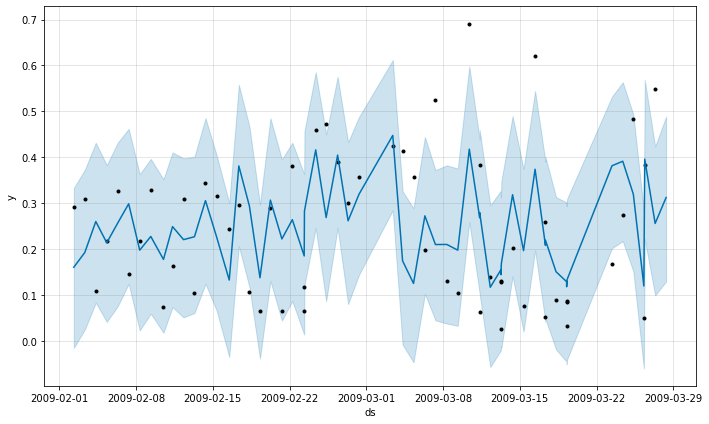

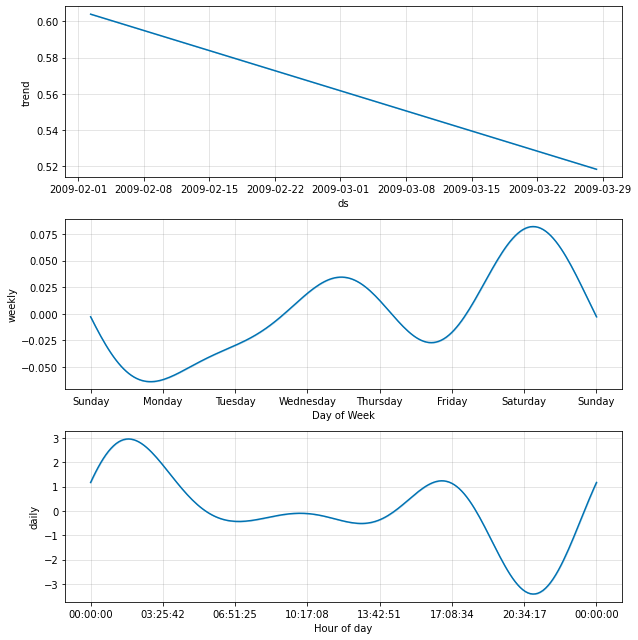

In [39]:
[upper,lower] = prop(0.1)

In [36]:
print(upper,lower)

0     0.322317
1     0.358363
2     0.446315
3     0.387869
4     0.417977
5     0.462731
6     0.365069
7     0.397219
8     0.348543
9     0.415997
10    0.389312
11    0.392076
12    0.469971
13    0.384157
14    0.294629
15    0.549002
16    0.441354
17    0.298456
18    0.471708
19    0.370629
20    0.437230
21    0.347506
22    0.450108
23    0.589014
24    0.440695
25    0.584895
26    0.433146
27    0.510779
28    0.636104
29    0.365463
30    0.314741
31    0.472116
32    0.395202
33    0.394824
34    0.382112
35    0.599627
36    0.447322
37    0.467972
38    0.291614
39    0.321022
40    0.318715
41    0.339367
42    0.491753
43    0.360294
44    0.540050
45    0.379858
46    0.388531
47    0.312237
48    0.301663
49    0.288761
50    0.298582
51    0.530040
52    0.549198
53    0.474330
54    0.261151
55    0.556143
56    0.399260
57    0.453443
Name: yhat_upper, dtype: float64 0    -0.000204
1     0.024512
2     0.098552
3     0.044418
4     0.092482
5     0.124043
6     0

In [35]:
from prophet import Prophet
dic_fr = {}
dic_pre = {}
for i in fr1:
    temp = []
    for j in range(len(fr1[i])):
        if fr1[i][j] != 0:
            temp.append(fr1[i][j])
    temp = temp[-6:-1]
    dic_fr[i] = temp
for i in dic_fr:
    if len(dic_fr[i]) == 5:
        dic_pre[i] = prop(dic_fr[i]).tolist()[-1]



NameError: name 'fr1' is not defined

In [156]:
dic_pre

{'M35': -27.049586822134245,
 'AD1-A': 6.521452147866253,
 'M34': -71.68171164484912,
 'M32': -42.03479819696514,
 'M33': 2.1226162818516583,
 'M36': 10.784977783599444,
 'M30': 6.5852652027390155,
 'M29': 1.9840870795791632,
 'M37': 23.559222949477522,
 'M38': 88.3829421677211,
 'M39': 43.86780990127596,
 'M41': 4.237321911515203,
 'M40': -66.91004205703075,
 'M31': 404.81085460322896,
 'M10': -7.602870579421904,
 'M14': 42.38241270461734,
 'M16': 15.519614501274773,
 'M15': 13.44703814494811,
 'M17': 5.880082331962058,
 'M51': 14.847467194700883,
 'M18': -3.3802365145520525,
 'AD1-B': 10.990679895850946,
 'M09': 9.376843652490159,
 'D08': 0.4326171816667497,
 'M45': -8.591266344660774,
 'M47': 126.42514114419549,
 'M48': 84.98089248009614,
 'M28': 1.440897379000738,
 'M27': 0.5740513852205122,
 'M46': 5.7250345937595135,
 'M49': 2.162130915703635,
 'M23': 28.82433376984183,
 'M19': 63.640167703932434,
 'M42': 6.44729605857046,
 'M08': 11.797042408081497,
 'M43': 9.910449580988065,
 '

-27.049586822134245

In [118]:
dic_fr

{'M35': [139.0, 22.0, 140.0, 4.0, 18.0],
 'AD1-A': [4.0, 2.0, 4.0, 6.0, 4.0],
 'M34': [15.0, 209.0, 177.0, 109.0, 47.0],
 'M32': [4.0, 44.0, 76.0, 32.0, 3.0],
 'M33': [2.0, 1.0, 1.0, 1.0, 2.0],
 'M36': [2.0, 2.0, 3.0, 5.0, 9.0],
 'M30': [1.0, 3.0, 4.0, 3.0, 7.0],
 'M29': [2.0, 4.0, 4.0, 1.0, 4.0],
 'M37': [3.0, 4.0, 4.0, 13.0, 18.0],
 'M38': [9.0, 15.0, 12.0, 52.0, 60.0],
 'M39': [4.0, 4.0, 4.0, 70.0, 6.0],
 'M41': [18.0, 6.0, 8.0, 2.0, 8.0],
 'M40': [16.0, 4.0, 4.0, 57.0, 6.0],
 'M31': [57.0, 737.0, 340.0, 223.0, 850.0],
 'M10': [40.0, 10.0, 63.0, 1.0, 13.0],
 'M14': [16.0, 38.0, 5.0, 13.0, 42.0],
 'M16': [32.0, 17.0, 28.0, 28.0, 10.0],
 'M15': [14.0, 12.0, 20.0, 30.0, 4.0],
 'M17': [30.0, 33.0, 40.0, 3.0, 17.0],
 'M51': [2.0, 4.0, 6.0, 23.0, 4.0],
 'M18': [18.0, 16.0, 60.0, 5.0, 15.0],
 'AD1-B': [3.0, 17.0, 30.0, 9.0, 15.0],
 'M09': [2.0, 34.0, 4.0, 34.0, 2.0],
 'D08': [4.0, 8.0, 2.0, 4.0, 2.0],
 'M45': [45.0, 27.0, 3.0, 2.0, 1.0],
 'M47': [11.0, 16.0, 6.0, 46.0, 92.0],
 'M48': [8.0,

In [71]:
dic['R1_Bed_to_Toilet_morning_date_time']

[Timestamp('2009-02-02 07:21:04'),
 Timestamp('2009-02-03 07:35:48'),
 Timestamp('2009-02-04 07:40:03'),
 Timestamp('2009-02-05 07:12:46'),
 Timestamp('2009-02-06 07:53:46'),
 Timestamp('2009-02-09 07:52:27'),
 Timestamp('2009-02-10 10:41:48'),
 Timestamp('2009-02-17 00:32:11'),
 Timestamp('2009-02-17 01:21:11'),
 Timestamp('2009-02-17 03:04:11'),
 Timestamp('2009-02-17 05:39:11'),
 Timestamp('2009-02-17 08:37:20'),
 Timestamp('2009-02-18 01:51:11'),
 Timestamp('2009-02-18 03:52:11'),
 Timestamp('2009-02-18 06:18:11'),
 Timestamp('2009-02-18 08:00:54'),
 Timestamp('2009-02-19 01:44:11'),
 Timestamp('2009-02-19 03:09:11'),
 Timestamp('2009-02-19 05:43:11'),
 Timestamp('2009-02-19 07:02:39'),
 Timestamp('2009-02-20 05:43:40'),
 Timestamp('2009-02-23 07:47:12'),
 Timestamp('2009-02-24 08:01:21'),
 Timestamp('2009-03-03 07:10:46'),
 Timestamp('2009-03-04 08:12:11'),
 Timestamp('2009-03-04 08:28:11'),
 Timestamp('2009-03-04 09:12:11'),
 Timestamp('2009-03-04 10:22:11'),
 Timestamp('2009-03-

In [132]:
get_up_time = []
for i in range(len(dic['R1_Sleep_date_time'])):
    a = dic['R1_Sleep_date_time'][i]
    get_up_time.append(a.hour+0.1*a.minute/60)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -51.7538
Iteration  1. Log joint probability =    48.8501. Improved by 100.604.
Iteration  2. Log joint probability =    95.5228. Improved by 46.6727.
Iteration  3. Log joint probability =    133.112. Improved by 37.5891.
Iteration  4. Log joint probability =    163.941. Improved by 30.8289.
Iteration  5. Log joint probability =    180.982. Improved by 17.0411.
Iteration  6. Log joint probability =     186.38. Improved by 5.39805.
Iteration  7. Log joint probability =    199.022. Improved by 12.6418.
Iteration  8. Log joint probability =    199.047. Improved by 0.0252453.
Iteration  9. Log joint probability =    199.152. Improved by 0.104621.
Iteration 10. Log joint probability =    199.161. Improved by 0.00944856.
Iteration 11. Log joint probability =    199.251. Improved by 0.0901443.
Iteration 12. Log joint probability =     199.35. Improved by 0.0991198.
Iteration 13. Log joint probability =    199.385. Improved by 0.0345304.
Iteration 14. Log joint

/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/zhuhaoxiang/opt/anaconda3/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pa

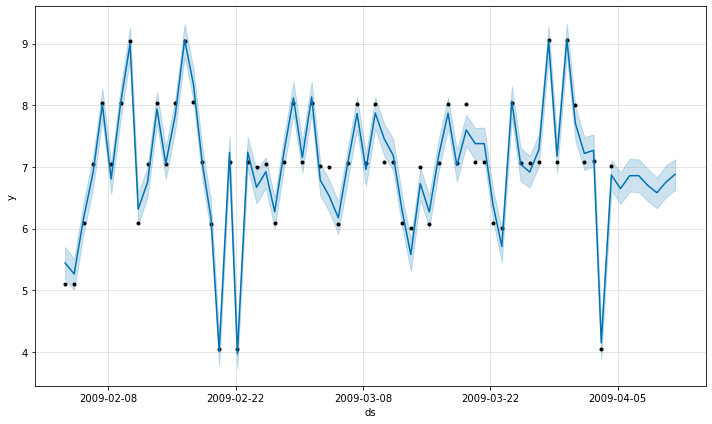

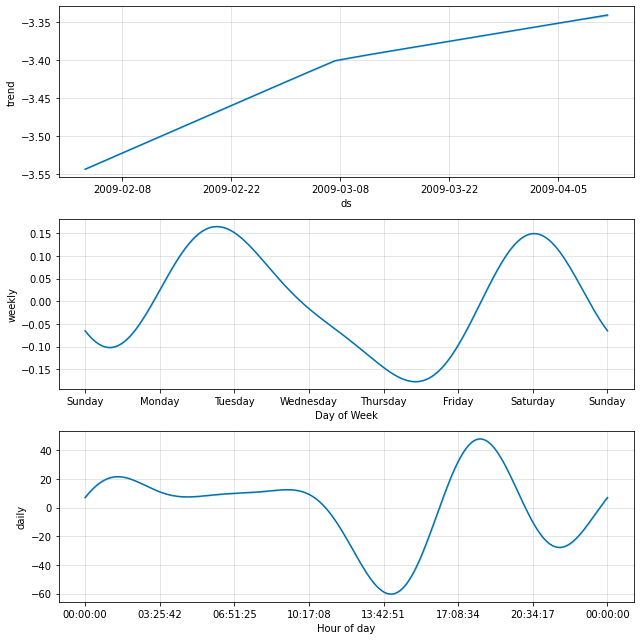

In [28]:
# Sleep_Pro = []
# for i in range(len(dic['R1_Sleep_dat'])):
#     if i % 2 != 0:
#         Sleep_Pro.append(dic['R1_Sleep'][i])
from prophet import Prophet
data = {'ds' : dic['R1_Sleep_date_time'], 'y' : get_up_time}
df = pd.DataFrame(data)

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [21]:
# fig1 = m.plot(forecast)
# dic['R2_Sleep_date_time']

In [19]:
# fig2 = m.plot_components(forecast)

In [47]:
# read auto.csv dataset
header = 0
index_col = None
names = ['date', 'time', 'type', 'state', 'location', 'be']
# auto_df = pd.read_csv('dataset_modified.csv',index_col = index_col, header = header ,names = names)
example = pd.read_csv('example.csv',index_col = 0)
# explore dtypes. Name is regarded as string object. Pandas recognizes it as non-numerical data 
# and automatically excludes this column from all the statistical analyses below. 

# head and tail of the dataframe
example

,date,time,type,state,location,BE
0,02/02/2009,07:15:17,M35,ON,R1_Bed_to_Toilet,begin
1,02/02/2009,07:15:21,AD1-A,2.82231,NaN,NaN
2,02/02/2009,07:15:23,M35,OFF,NaN,NaN


In [ ]:
# cnt = 0
# i0 = []
# name1 = 'R1_Work'
# temp=[0,0]
# for i in range(0,138631):
#     if auto_df['location'][i] == name1:
#         cnt+=1
# cnt

In [ ]:
for i in range(example.shape[0]):
    if i == 1: 
        example.drop(labels = i,axis = 0,inplace = True)
example

In [ ]:
example.reset_index(drop = True)

In [26]:
# name1 = 'R1_Work'
# for i in range(0,138631):
#     if auto_df['location'][i] == name1:
#         print(auto_df.iloc[i], '\n')
     

In [87]:
439589/3600

122.10805555555555

In [23]:

data =pd.DataFrame(dict([(k, pd.Series(v)) for k, v in dic_delta.items()]))

In [24]:
data

,R1_Bed_to_Toilet,R1_Personal_Hygiene,R2_Bed_to_Toilet,Meal_Preparation,R2_Personal_Hygiene,Watch_TV,R1_Work,R2_Work,R1_Sleep,R2_Sleep,Wash_Bathtub,Clean,Study
0,0.096389,0.291667,0.045000,0.134722,0.433333,0.824444,3.138611,2.222778,7.774167,7.715000,0.551389,0.539444,2.151667
1,0.103889,0.108333,0.102778,0.367222,0.043889,1.150000,0.496944,1.133889,7.513333,7.493889,NaN,0.289722,0.546111
2,0.234167,0.065556,0.068889,1.160278,0.583333,2.314722,1.207222,1.798889,7.933889,8.838889,NaN,NaN,3.241389
3,0.350556,0.326944,0.042500,9.857222,0.572222,1.342778,1.711389,0.674722,8.366389,9.412778,NaN,NaN,0.655000
4,0.332222,0.327778,0.038611,0.644167,0.691667,3.805278,3.213056,1.521389,8.506389,8.914722,NaN,NaN,3.000556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NaN,NaN,NaN,0.587500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,0.171389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,0.231389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,0.615833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data.to_csv('fuze.csv')